In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
packt_palette = ["#f97141","#535555", "#89452D", "#1a1a1a",  "#573428",    "#E4E7ED"]
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('combined_data.xlsx')

In [3]:
df.head()

,UID,application,request_id,request_type,request_status,account_name,entitlement,entitlement_value,approval_type,approver,approved_on,approval_status,requested_on,Unnamed: 0,employeeType,dept,div,hrOrganizationCode
0,requestee_0,Application_0,requestID_0,Modify Account,Approval Complete,account_0,entitlement_0,ent_val_0,app_type_0,approver_0,2020-04-29 19:37:00,Rejected,2020-04-20,201917,emType_2,dept_8828,div_60,hrCode_34
1,requestee_0,Application_0,requestID_0,Modify Account,Approval Complete,account_0,entitlement_0,ent_val_0,app_type_2,approver_33,2020-04-20 18:36:00,Approved,2020-04-20,201917,emType_2,dept_8828,div_60,hrCode_34
2,requestee_0,Application_26,requestID_4093,New Account,Approval Complete,account_0,entitlement_2,ent_val_6,app_type_28,approver_33,2020-04-23 18:47:00,Approved,2020-04-23,201917,emType_2,dept_8828,div_60,hrCode_34
3,requestee_1,Application_0,requestID_1,Modify Account,Approval Complete,account_1,entitlement_0,ent_val_1,app_type_1,approver_1,2020-04-21 05:00:00,Approved,2020-04-21,197651,emType_2,dept_9022,div_13,hrCode_116
4,requestee_10,Application_0,requestID_10,Modify Account,Approval Complete,account_10,entitlement_0,ent_val_3,app_type_2,approver_11,2020-04-20 05:42:00,Approved,2020-04-17,246295,emType_2,dept_6732,div_387,hrCode_11


In [4]:
print(df.shape)

(232281, 18)


In [5]:
df.isnull().sum()

UID                   0
application           0
request_id            0
request_type          0
request_status        0
account_name          0
entitlement           0
entitlement_value     0
approval_type         0
approver              0
approved_on           0
approval_status       0
requested_on          0
Unnamed: 0            0
employeeType          0
dept                  0
div                   0
hrOrganizationCode    0
dtype: int64

### EDA

In [6]:
df.columns

Index(['UID', 'application', 'request_id', 'request_type', 'request_status',
       'account_name', 'entitlement', 'entitlement_value', 'approval_type',
       'approver', 'approved_on', 'approval_status', 'requested_on',
       'Unnamed: 0', 'employeeType', 'dept', 'div', 'hrOrganizationCode'],
      dtype='object')

In [7]:
df['application'].nunique()

1095

In [8]:
df['request_id'].nunique()

47746

47K unique request_ids in a dataset of 233K

Text(0, 0.5, 'Count')

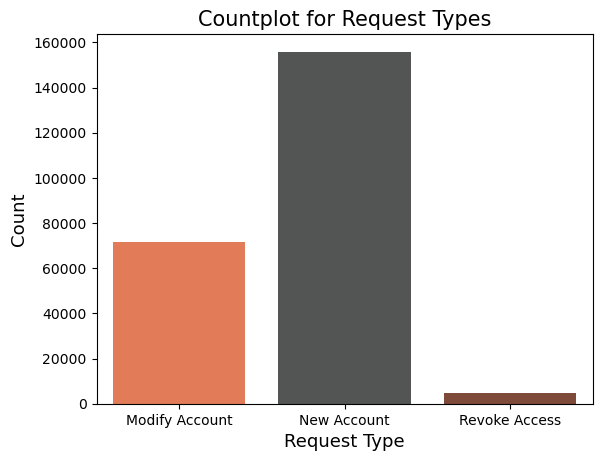

In [9]:
sns.countplot(x='request_type', data=df, palette=packt_palette)
plt.title('Countplot for Request Types', size=15)
plt.xlabel('Request Type', size=13)
plt.ylabel('Count', size=13)

Hence, most of the Request Types are for the creation of new accounts

Text(0, 0.5, 'Count')

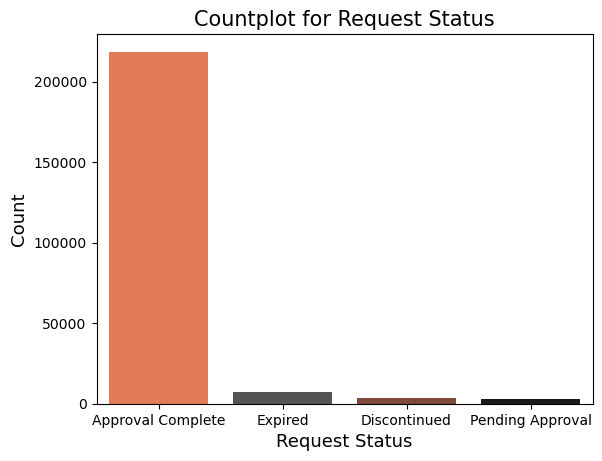

In [10]:
sns.countplot(x='request_status', data=df, palette=packt_palette)
plt.title('Countplot for Request Status', size=15)
plt.xlabel('Request Status', size=13)
plt.ylabel('Count', size=13)

For most of the requests, approval was completed

In [11]:
print(df['account_name'].nunique())
print(df['entitlement'].nunique())

28357
253


In [12]:
print(df['entitlement_value'].nunique())
print(df['approver'].nunique())
print(df['approval_type'].nunique())

15238
13473
237


Text(0, 0.5, 'Count')

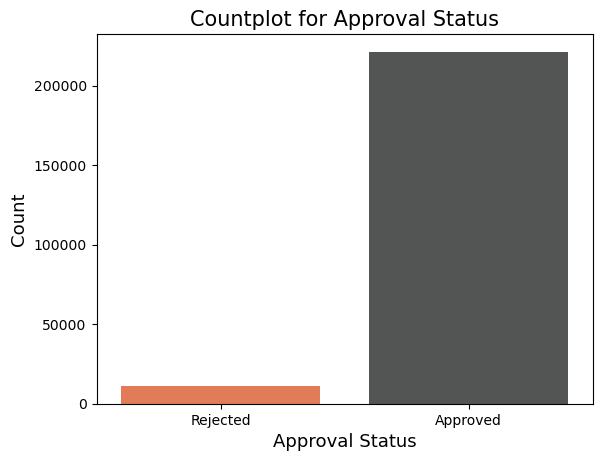

In [13]:
sns.countplot(x='approval_status', data=df, palette=packt_palette)
plt.title('Countplot for Approval Status', size=15)
plt.xlabel('Approval Status', size=13)
plt.ylabel('Count', size=13)

In [14]:
df['approval_status'].value_counts()

Approved    221414
Rejected     10867
Name: approval_status, dtype: int64

Most of the requests were approved

Text(0, 0.5, 'Count')

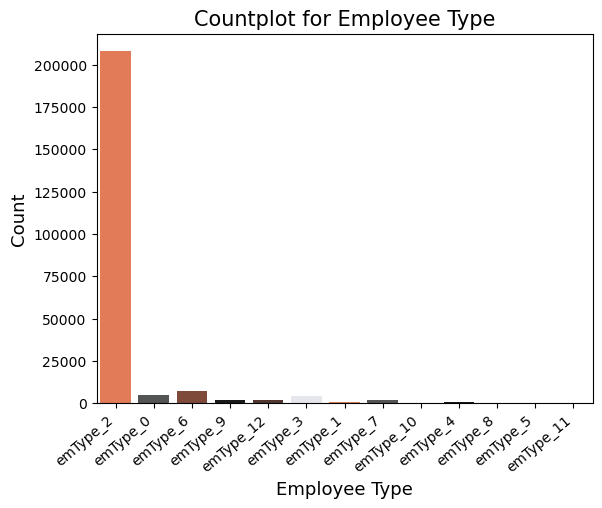

In [15]:
ax= sns.countplot(x='employeeType', data=df, palette=packt_palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.title('Countplot for Employee Type', size=15)
plt.xlabel('Employee Type', size=13)
plt.ylabel('Count', size=13)

EmpType2 has significantly more representation than other employee types

In [16]:
print(df['dept'].nunique())
print(df['div'].nunique())
print(df['hrOrganizationCode'].nunique())

13360
473
572


## Classification Models (on imbalanced data)

In [3]:
# Dropping the unnamed column and creating a new column for time_taken

df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['approved_on']  = pd.to_datetime(df.approved_on)

df['requested_on'] = pd.to_datetime(df.requested_on)

df['time_taken'] = (df['approved_on']  - df['requested_on']).dt.total_seconds()/(3600*24)

In [4]:
df.drop(['approved_on', 'requested_on', 'approver', 'time_taken', 'UID', 'request_id'], axis=1, inplace=True)

In [5]:
df.shape

(232281, 12)

In [8]:
df.columns

Index(['application', 'request_type', 'request_status', 'account_name',
       'entitlement', 'entitlement_value', 'approval_type', 'approval_status',
       'employeeType', 'dept', 'div', 'hrOrganizationCode'],
      dtype='object')

In [9]:
# Encoding the target variable

df['approval_status'][df['approval_status'] == 'Approved'] = 1
df['approval_status'][df['approval_status'] == 'Rejected'] = 0

In [10]:
# Dividing into dependent and independent variables

X = df.drop(['approval_status'], axis=1)
y = df['approval_status']

In [11]:
y = y.astype('int')

In [12]:
# Encoding the independent variables (features)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for col in X.columns:
    X[col] = encoder.fit_transform(X[col])

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#### Logistic Regression, Decision Tree, Random Forest

Accuracy Score for Logistic Regression:  0.9540753177703873
F1 Score for Logistic Regression:  0.9764964444468924

----------------------------------------------------------------------------------------------------------

Accuracy Score for Decision Tree Classifier:  0.9728240396930462
F1 Score for Decision Tree Classifier:  0.9857392168712125

----------------------------------------------------------------------------------------------------------

Accuracy Score for Random Forest Classifier:  0.9814450076953709
F1 Score for Random Forest Classifier:  0.990343359659441



Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

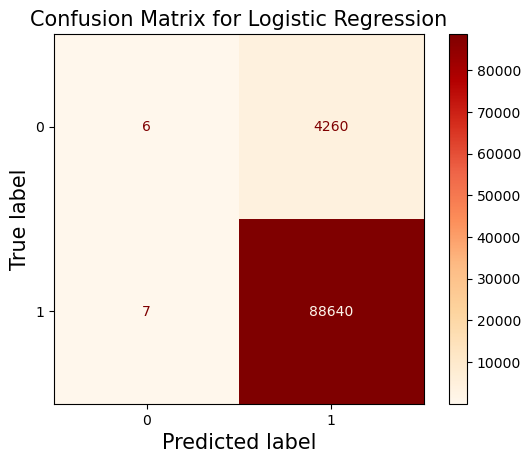

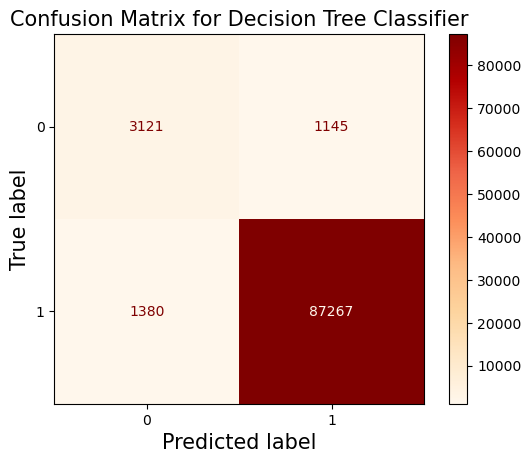

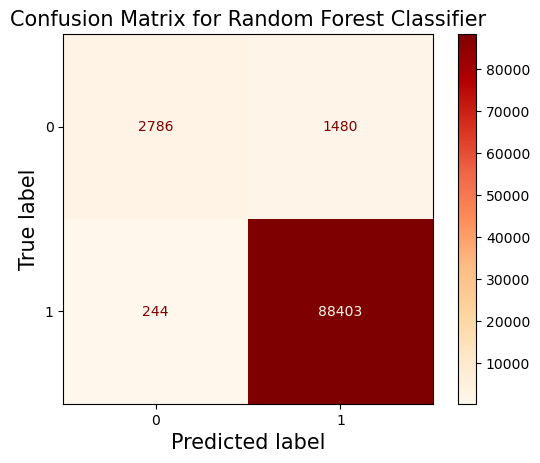

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix


lr = LogisticRegression()
lr.fit(x_train, y_train)
y_preds_lr = lr.predict(x_test)
print("Accuracy Score for Logistic Regression: ", accuracy_score(y_preds_lr, y_test))
print("F1 Score for Logistic Regression: ", f1_score( y_test, y_preds_lr))
print()
plot_confusion_matrix(lr, x_test, y_test, cmap="OrRd")
plt.ylabel('True label', size=15)
plt.xlabel('Predicted label', size=15)
plt.title('Confusion Matrix for Logistic Regression', size=15)
print("----------------------------------------------------------------------------------------------------------")
print()

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_preds_dt = dt.predict(x_test)
print("Accuracy Score for Decision Tree Classifier: ", accuracy_score(y_preds_dt, y_test))
print("F1 Score for Decision Tree Classifier: ", f1_score(y_test, y_preds_dt))
print()
plot_confusion_matrix(dt, x_test, y_test, cmap="OrRd")
plt.ylabel('True label', size=15)
plt.xlabel('Predicted label', size=15)
plt.title('Confusion Matrix for Decision Tree Classifier', size=15)
print("----------------------------------------------------------------------------------------------------------")
print()


rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_preds_rf = rf.predict(x_test)
print("Accuracy Score for Random Forest Classifier: ", accuracy_score(y_preds_rf, y_test))
print("F1 Score for Random Forest Classifier: ", f1_score(y_test, y_preds_rf))
print()
plot_confusion_matrix(rf, x_test, y_test, cmap="OrRd")
plt.ylabel('True label', size=15)
plt.xlabel('Predicted label', size=15)
plt.title('Confusion Matrix for Random Forest Classifier', size=15)


In [14]:
x_test.shape

(92913, 11)

### XGBoost Classifier

[10:46:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score of XGBoost Classifier:  0.9739864174012248
F1 Score of XGBoost Classifier:  0.9865285898214774


Text(0.5, 1.0, 'Confusion Matrix of XGBoost Classifier')

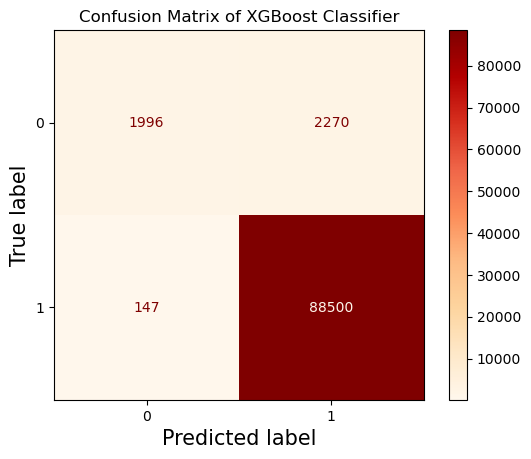

In [26]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False)

xgb.fit(x_train, y_train)

y_preds_xgb = xgb.predict(x_test)

print("Accuracy Score of XGBoost Classifier: ", accuracy_score(y_preds_xgb, y_test))
print("F1 Score of XGBoost Classifier: ", f1_score( y_test, y_preds_xgb))

plot_confusion_matrix(xgb, x_test, y_test, cmap="OrRd")
plt.ylabel('True label', size=15)
plt.xlabel('Predicted label', size=15)
plt.title('Confusion Matrix of XGBoost Classifier')

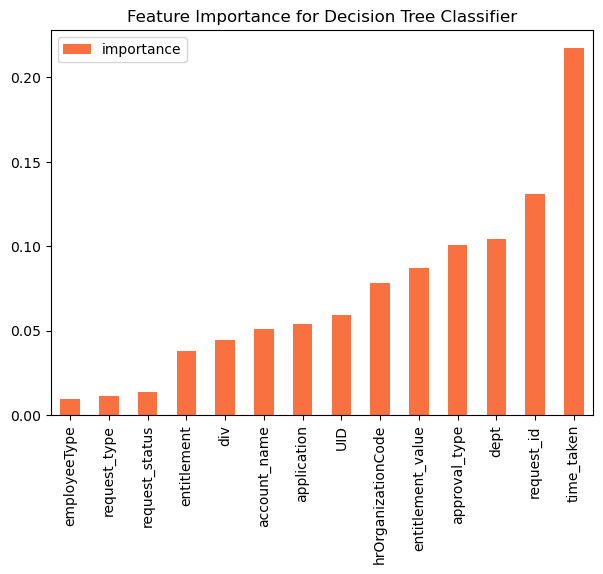

In [27]:
fg, ax = plt.subplots(figsize = (7,5))
feat_imp = pd.DataFrame(dt.feature_importances_, index = X.columns, columns = ['importance'])
feat_imp.sort_values('importance').plot(kind = 'bar', title = 'Feature Importance for Decision Tree Classifier',ax = ax, color='#f97141')
plt.show()

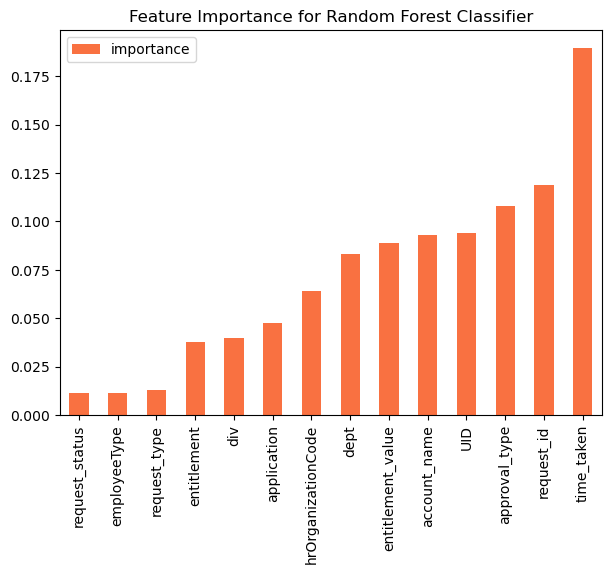

In [28]:
fg, ax = plt.subplots(figsize = (7,5))
feat_imp = pd.DataFrame(rf.feature_importances_, index = X.columns, columns = ['importance'])
feat_imp.sort_values('importance').plot(kind = 'bar', title = 'Feature Importance for Random Forest Classifier',ax = ax, color='#f97141')
plt.show()

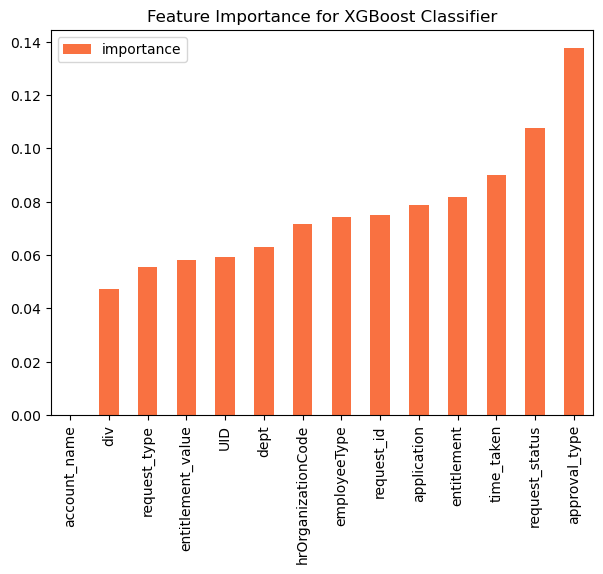

In [29]:
fg, ax = plt.subplots(figsize = (7,5))
feat_imp = pd.DataFrame(xgb.feature_importances_, index = X.columns, columns = ['importance'])
feat_imp.sort_values('importance').plot(kind = 'bar', title = 'Feature Importance for XGBoost Classifier',ax = ax, color='#f97141')
plt.show()

# Modelling after random oversampling and undersampling

In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
ros = RandomOverSampler()

x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

### RandomForestClassifier on oversampled data

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
rf_ros = RandomForestClassifier()
rf_ros.fit(x_train_ros, y_train_ros)

y_preds_rf_ros = rf_ros.predict(x_test)

print("Accuracy score for the RandomForestClassifier on oversampled data: ", accuracy_score(y_preds_rf_ros, y_test))
print("F1 Score for the RandomForestClassifier on oversampled data: ", f1_score(y_test, y_preds_rf_ros))

Accuracy score for the RandomForestClassifier on oversampled data:  0.9702302153627587
F1 Score for the RandomForestClassifier on oversampled data:  0.9844393438196178


In [21]:
x_train_ros.head()

,application,request_type,request_status,account_name,entitlement,entitlement_value,approval_type,employeeType,dept,div,hrOrganizationCode
0,214,1,1,17,161,7207,206,5,4577,4,334
1,508,1,0,705,0,11116,160,9,1750,440,246
2,365,1,0,7372,109,11369,160,0,1048,440,268
3,444,1,2,17324,37,14719,186,5,4053,186,35
4,365,1,0,7726,109,11369,160,5,4314,157,268


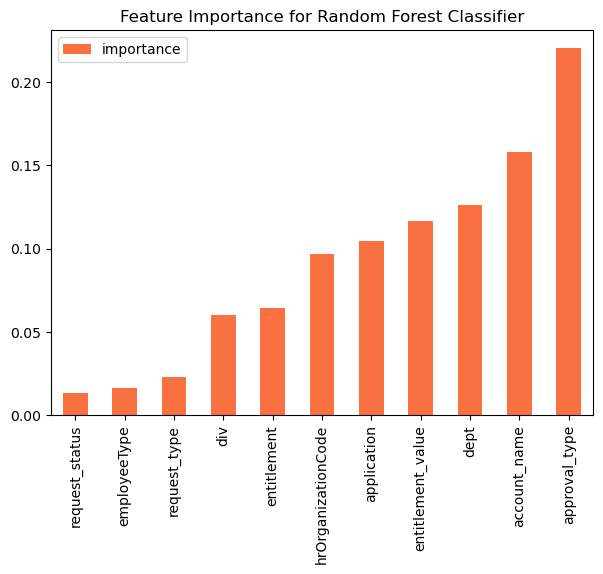

In [24]:
fg, ax = plt.subplots(figsize = (7,5))
feat_imp = pd.DataFrame(rf_ros.feature_importances_, index = X.columns, columns = ['importance'])
feat_imp.sort_values('importance').plot(kind = 'bar', title = 'Feature Importance for Random Forest Classifier',ax = ax, color='#f97141')
plt.show()


























### RandomForestClassifier on undersampled data

In [34]:
rf_rus = RandomForestClassifier()

rf_rus.fit(x_train_rus, y_train_rus)

y_preds_rf_rus = rf_rus.predict(x_test)

print("Accuracy Score for the RandomForestClassifier on undersampled data: ", accuracy_score(y_preds_rf_rus, y_test))
print("F1 Score for the RandomForestClassifier on undersampled data: ", f1_score(y_test, y_preds_rf_rus))

Accuracy Score for the RandomForestClassifier on undersampled data:  0.8958595675524416
F1 Score for the RandomForestClassifier on undersampled data:  0.9426138115911086


### DecisionTree Classifier on oversampled data

In [35]:
dt_ros = DecisionTreeClassifier()

dt_ros.fit(x_train_ros, y_train_ros)

y_preds_dt_ros = dt_ros.predict(x_test)

print("Accuracy score for the DecisionTreeClassifier on oversampled data: ", accuracy_score(y_preds_dt_ros, y_test))
print("F1 Score for the DecisionTreeClassifier on oversampled data: ", f1_score(y_test, y_preds_dt_ros))

Accuracy score for the DecisionTreeClassifier on oversampled data:  0.9747613358733439
F1 Score for the DecisionTreeClassifier on oversampled data:  0.9867771857114663


### Decision Tree Classifier on undersampled data

In [37]:
dt_rus = DecisionTreeClassifier()

dt_rus.fit(x_train_rus, y_train_rus)

y_preds_dt_rus = dt_rus.predict(x_test)

print("Accuracy score for the DecisionTreeClassifier on undersampled data: ", accuracy_score(y_preds_dt_rus, y_test))
print("F1 Score for the DecisionTreeClassifier on undersampled data: ", f1_score(y_test, y_preds_dt_rus))

Accuracy score for the DecisionTreeClassifier on undersampled data:  0.8220162948134276
F1 Score for the DecisionTreeClassifier on undersampled data:  0.897861117802195


### Logistic Regression on oversampled data

In [41]:
lr_ros = LogisticRegression()
lr_ros.fit(x_train_ros, y_train_ros)

y_preds_lr_ros = lr_ros.predict(x_test)

print("Accuracy score for the LogisticRegression Classifier on oversampled data: ", accuracy_score(y_preds_lr_ros, y_test))
print("F1 Score for the LogisticRegression Classifier on oversampled data: ", f1_score(y_test, y_preds_lr_ros))

Accuracy score for the LogisticRegression Classifier on oversampled data:  0.6703582921657895
F1 Score for the LogisticRegression Classifier on oversampled data:  0.7962778199039522


### Logistic Regression on undersampled data

In [42]:
lr_rus = LogisticRegression()
lr_rus.fit(x_train_rus, y_train_rus)

y_preds_lr_rus = lr_rus.predict(x_test)

print("Accuracy score for the LogisticRegression Classifier on undersampled data: ", accuracy_score(y_preds_lr_rus, y_test))
print("F1 Score for the LogisticRegression Classifier on undersampled data: ", f1_score(y_test, y_preds_lr_rus))

Accuracy score for the LogisticRegression Classifier on undersampled data:  0.6733933895149226
F1 Score for the LogisticRegression Classifier on undersampled data:  0.7984645423512692


### XGBoost on oversampled data

In [45]:
xgb_ros = XGBClassifier()
xgb_ros.fit(x_train_ros, y_train_ros)

y_preds_xgb_ros = xgb_ros.predict(x_test)

print("Accuracy Score for XGBoost Classifier on oversampled data: ", accuracy_score(y_preds_xgb_ros, y_test))
print("F1 Score for XGBoost Classifier on oversampled data: ", f1_score(y_test, y_preds_xgb_ros))

[10:57:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score for XGBoost Classifier on oversampled data:  0.9209260275741823
F1 Score for XGBoost Classifier on oversampled data:  0.9571326047762693


### XGBoost on undersampled data

In [46]:
xgb_rus = XGBClassifier()
xgb_rus.fit(x_train_rus, y_train_rus)

y_preds_xgb_rus = xgb_rus.predict(x_test)

print("Accuracy Score for XGBoost Classifier on undersampled data: ", accuracy_score(y_preds_xgb_rus, y_test))
print("F1 Score for XGBoost Classifier on undersampled data: ", f1_score(y_test, y_preds_xgb_rus))

[10:57:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score for XGBoost Classifier on undersampled data:  0.864948930720136
F1 Score for XGBoost Classifier on undersampled data:  0.924327584127367


In conclusion, RandomForestClassifier on randomly oversampled data performs the best. 

## Saving the model in a pickle

In [23]:
import pickle
pickle.dump(rf_ros, open('final_model.pkl', 'wb'))
pickle

<module 'pickle' from 'C:\\Users\\SinjiniGhosh\\anaconda3\\lib\\pickle.py'>